In [248]:
import torch
from torch import nn, optim, Tensor
from tqdm import tqdm
from torch.optim import AdamW
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from typing import List, NamedTuple
from einops import rearrange
from torch.utils.data import DataLoader, TensorDataset

from kmeans import kmeans_init_

%matplotlib inline

# Generate Semantic IDs

In [249]:
def efficient_rotation_trick_transform(u, q, e):
    """
    4.2 in https://arxiv.org/abs/2410.06424
    """
    e = rearrange(e, 'b d -> b 1 d')
    w = F.normalize(u + q, p=2, dim=1, eps=1e-6).detach()

    return (
        e -
        2 * (e @ rearrange(w, 'b d -> b d 1') @ rearrange(w, 'b d -> b 1 d')) +
        2 * (e @ rearrange(u, 'b d -> b d 1').detach() @ rearrange(q, 'b d -> b 1 d').detach())
    ).squeeze()
    
def l2norm(x, dim=-1, eps=1e-12):
    return F.normalize(x, p=2, dim=dim, eps=eps)


class L2NormalizationLayer(nn.Module):
    def __init__(self, dim=-1, eps=1e-12) -> None:
        super().__init__()
        self.dim = dim
        self.eps = eps

    def forward(self, x) -> Tensor:
        return l2norm(x, dim=self.dim, eps=self.eps)
    
class QuantizeLoss(nn.Module):
    def __init__(self, commitment_weight: float = 1.0) -> None:
        super().__init__()
        self.mse_loss = nn.MSELoss(reduction='sum')
        self.commitment_weight = commitment_weight

    def forward(self, query: Tensor, value: Tensor) -> Tensor:
        emb_loss = self.mse_loss(query.detach(), value)
        query_loss = self.mse_loss(query, value.detach())
        return emb_loss + self.commitment_weight * query_loss
    
class ReconstructionLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x_hat: Tensor, x: Tensor) -> Tensor:
        return ((x_hat - x)**2).sum(axis=-1)


class CategoricalReconstuctionLoss(nn.Module):
    def __init__(self, n_cat_feats: int) -> None:
        super().__init__()
        self.reconstruction_loss = ReconstructionLoss()
        self.n_cat_feats = n_cat_feats
    
    def forward(self, x_hat: Tensor, x: Tensor) -> Tensor:
        reconstr = self.reconstruction_loss(
            x_hat[:, :-self.n_cat_feats],
            x[:, :-self.n_cat_feats]
        )
        if self.n_cat_feats > 0:
            cat_reconstr = nn.functional.binary_cross_entropy_with_logits(
                x_hat[:, -self.n_cat_feats:],
                x[:, -self.n_cat_feats:],
                reduction='none'
            ).sum(axis=-1)
            reconstr += cat_reconstr
        return reconstr

In [250]:
class MLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dims: List[int],
        out_dim: int,
        dropout: float = 0.0,
        normalize: bool = False,
        eps = 1e-12,
    ) -> None:
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.out_dim = out_dim
        self.dropout = dropout
        self.eps = eps

        dims = [self.input_dim] + self.hidden_dims + [self.out_dim]
        
        self.mlp = nn.Sequential()
        for i, (in_d, out_d) in enumerate(zip(dims[:-1], dims[1:])):
            self.mlp.append(nn.Linear(in_d, out_d, bias=False))
            if i != len(dims)-2:
                self.mlp.append(nn.SiLU())
                self.mlp.append(nn.LayerNorm(out_d)),
                if dropout != 0:
                    self.mlp.append(nn.Dropout(dropout))

        self.mlp.append(
            L2NormalizationLayer(dim=-1, eps=self.eps)
            if normalize else nn.Identity())

    def forward(self, x: Tensor) -> Tensor:
        return self.mlp(x)
    
class Quantization(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        n_embed: int,
        do_kmeans_init: bool = True,
        codebook_normalize: bool = False,
        sim_vq: bool = False,  # https://arxiv.org/pdf/2411.02038
        commitment_weight: float = 0.25,
    ):
        super().__init__()
        
        self.embed_dim = embed_dim
        self.n_embed = n_embed
        self.embedding = nn.Embedding(self.n_embed, self.embed_dim)
        
        self.do_kmeans_init = do_kmeans_init
        self.kmeans_initted = False
        
        self.codebook_normalize = codebook_normalize
        self.sim_vq = sim_vq
        self.commitment_weight = commitment_weight
        
        self.out_proj = nn.Sequential(
            nn.Linear(embed_dim, embed_dim, bias=False) if sim_vq else nn.Identity(),
            L2NormalizationLayer(dim=-1) if codebook_normalize else nn.Identity()
        )
        
        self.quantize_loss = QuantizeLoss(commitment_weight)
        
        nn.init.uniform_(self.embedding.weight)
        
    @torch.no_grad
    def _kmeans_init(self, x) -> None:
        kmeans_init_(self.embedding.weight, x=x)
        self.kmeans_initted = True
    
    def get_item_embeddings(self, item_ids) -> Tensor:
        return self.out_proj(self.embedding(item_ids))
    
    def forward(self, x, temperature = 1.25):
        
        #if self.do_kmeans_init and not self.kmeans_initted:
        #    self._kmeans_init(x=x)

        codebook = self.out_proj(self.embedding.weight)
    
        dist = (
            (x**2).sum(axis=1, keepdim=True) +
            (codebook.T**2).sum(axis=0, keepdim=True) -
            2 * x @ codebook.T
        ) /temperature
        probs = F.softmax(-dist, dim=1)
        ids = torch.multinomial(probs, num_samples=1).squeeze(1)
        # Cosine Theoretically
        #dist = -(
        #    x / x.norm(dim=1, keepdim=True) @
        #    (codebook.T) / codebook.T.norm(dim=0, keepdim=True)
        #)

        if self.training:
            emb = self.get_item_embeddings(ids)
            emb_out = efficient_rotation_trick_transform(
                x / (x.norm(dim=-1, keepdim=True) + 1e-8),
                emb / (emb.norm(dim=-1, keepdim=True) + 1e-8),
                x
            )
            
            loss = self.quantize_loss(query=x, value=emb)
        else:
            emb_out = self.get_item_embeddings(ids)
            loss = self.quantize_loss(query=x, value=emb_out)

        return emb_out, ids, loss

In [251]:
torch.set_float32_matmul_precision('high')


class RqVaeOutput(NamedTuple):
    embeddings: Tensor
    residuals: Tensor
    sem_ids: Tensor
    quantize_loss: Tensor


class RqVaeComputedLosses(NamedTuple):
    loss: Tensor
    reconstruction_loss: Tensor
    rqvae_loss: Tensor
    embs_norm: Tensor
    p_unique_ids: Tensor
    
class SeqBatch(NamedTuple):
    user_ids: Tensor
    ids: Tensor
    ids_fut: Tensor
    x: Tensor
    x_fut: Tensor
    seq_mask: Tensor

class RQ_VAE(nn.Module):
    def __init__(
        self,
        input_dim: int,
        embed_dim: int,
        hidden_dims: List[int],
        codebook_size: int,
        codebook_kmeans_init: bool = True,
        codebook_normalize: bool = False,
        codebook_sim_vq: bool = False,
        n_layers: int = 3,
        commitment_weight: float = 0.25,
        n_cat_features: int = 0,
    ) -> None:
        self._config = locals()
        
        super().__init__()

        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.hidden_dims = hidden_dims
        self.n_layers = n_layers
        self.codebook_size = codebook_size
        self.commitment_weight = commitment_weight
        self.n_cat_feats = n_cat_features
        
        self.layers = nn.ModuleList(modules=[
            Quantization(
                embed_dim=embed_dim,
                n_embed=codebook_size,
                do_kmeans_init=codebook_kmeans_init,
                codebook_normalize=i == 0 and codebook_normalize,
                sim_vq=codebook_sim_vq,
                commitment_weight=commitment_weight
            ) for i in range(n_layers)
        ])
        
        self.encoder = MLP(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            out_dim=embed_dim,
            normalize=codebook_normalize
        )

        self.decoder = MLP(
            input_dim=embed_dim,
            hidden_dims=hidden_dims[-1::-1],
            out_dim=input_dim,
            normalize=True
        )
        
        self.reconstruction_loss = (
            CategoricalReconstuctionLoss(n_cat_features) if n_cat_features != 0
            else ReconstructionLoss()
        )
        
    def encode(self, x: Tensor) -> Tensor:
        return self.encoder(x)

    def decode(self, x: Tensor) -> Tensor:
        return self.decoder(x)
    
    def get_semantic_ids(
        self,
        x: Tensor,
        train = True
    ) -> RqVaeOutput:
        res = self.encode(x)
        
        quantize_loss = 0
        embs, residuals, sem_ids = [], [], []

        for layer in self.layers:
            residuals.append(res)
            emb_out, ids, loss = layer(res)
            quantize_loss += loss
            emb, id = emb_out, ids
            res = res - emb
            
            sem_ids.append(id)
            embs.append(emb)
            
        if not train:
            embs = [embs[0].unsqueeze(0)]  # Add an extra dimension for layers
            #residuals = [residuals[0].unsqueeze(0)]
            #sem_ids = [sem_ids[0].unsqueeze(0)]

        return RqVaeOutput(
            embeddings=rearrange(embs, "b h d -> h d b"),
            residuals=rearrange(residuals, "b h d -> h d b"),
            sem_ids=rearrange(sem_ids, "b d -> d b"),
            quantize_loss=quantize_loss
        )
        
    #@torch.compile(mode="reduce-overhead")
    def forward(self, batch: SeqBatch) -> RqVaeComputedLosses:
        x = batch.x
        quantized = self.get_semantic_ids(x)
        embs, residuals = quantized.embeddings, quantized.residuals
        x_hat = self.decode(embs.sum(axis=-1))

        reconstuction_loss = self.reconstruction_loss(x_hat, x)
        rqvae_loss = quantized.quantize_loss
        loss = (reconstuction_loss + rqvae_loss).mean()
        
        with torch.no_grad():
            # Compute debug ID statistics
            embs_norm = embs.norm(dim=1)
            p_unique_ids = (~torch.triu(
                (rearrange(quantized.sem_ids, "b d -> b 1 d") == rearrange(quantized.sem_ids, "b d -> 1 b d")).all(axis=-1), diagonal=1)
            ).all(axis=1).sum() / quantized.sem_ids.shape[0]

        return RqVaeComputedLosses(
            loss=loss,
            reconstruction_loss=reconstuction_loss.mean(),
            rqvae_loss=rqvae_loss.mean(),
            embs_norm=embs_norm,
            p_unique_ids=p_unique_ids
        )

In [252]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained model
trans_model = SentenceTransformer('all-MiniLM-L6-v2')

dataset = pd.read_csv('data/lfm_items.csv', sep='\t', index_col=0)
embeddings = []
for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
    x = dict(row.items())
    x = str(x['song']) + " from " + str(x['artist']) + " in " +str(x['album_name']) + " with tags " + str(x['genre'])
    emb = trans_model.encode(x)
    
    embeddings.append(emb)
embeddings = np.array(embeddings)
np.save('data/lfm_items_embeddings.npy', embeddings)

100%|██████████| 4178/4178 [00:32<00:00, 128.64it/s]


In [253]:
#save_model_every=5000
#data_folder="data/lfm"
#data="data/"
#save_dir_root="out/rqvae/lfm/"
#wandb_logging=True
#vae_codebook_mode="modules.quantize.QuantizeForwardMode.ROTATION_TRICK"
#force_data_process=False
#data_split="beauty"

In [ ]:
embeddings = np.load('data/lfm_items_embeddings.npy')

emb_shape = np.array(embeddings).shape
vae_input_dim = emb_shape[1]
vae_hidden_dims=[512, 256, 128]
vae_embed_dim=32

vae_codebook_size=256
vae_codebook_normalize=True
vae_sim_vq=False
vae_n_layers=2

eval_every=5000
do_eval=True

use_kmeans_init=False

learning_rate=0.0005
weight_decay=0.01

batch_size=64
commitment_weight=0.25
iterations=400000

In [261]:
embeddings = torch.tensor(embeddings, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(embeddings), batch_size=batch_size, shuffle=True)

In [324]:
import torch.optim as optim

model = RQ_VAE(
    input_dim=vae_input_dim,
    embed_dim=vae_embed_dim,
    hidden_dims=vae_hidden_dims,
    codebook_size=vae_codebook_size,
    codebook_kmeans_init=use_kmeans_init,
    codebook_normalize=vae_codebook_normalize,
    codebook_sim_vq=vae_sim_vq,
    n_layers=vae_n_layers,
    commitment_weight=commitment_weight
)

def train(num_epochs=250): 
    # Set up optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        
        total_loss = 0
        total_reconstruction_loss = 0
        total_rqvae_loss = 0
        
        for batch_idx, (embeddings_batch,) in enumerate(train_loader):
            batch = SeqBatch(
                user_ids=None,  # Adjust if you have user-based data
                ids=None,  # Adjust if you have IDs
                ids_fut=None,
                x=embeddings_batch,
                x_fut=None,
                seq_mask=None  # Adjust if you have masks
            )
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            losses = model(batch)
            #for layer in model.layers:
            #    layer.commitment_weight *= (1-weight_decay)
            
            # Backpropagate
            losses.loss.backward()
            optimizer.step()
            
            total_loss += losses.loss.item()
            total_reconstruction_loss += losses.reconstruction_loss.item()
            total_rqvae_loss += losses.rqvae_loss.item()
        
        # Print epoch statistics
        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss/len(train_loader):.4f} | "
            f"Reconstruction Loss: {total_reconstruction_loss/len(train_loader):.4f} | "
            f"RQ-VAE Loss: {total_rqvae_loss/len(train_loader):.4f}")
        
train(10)

Epoch [1/10] | Loss: 1523.0684 | Reconstruction Loss: 0.7622 | RQ-VAE Loss: 1522.3062
Epoch [2/10] | Loss: 1365.4087 | Reconstruction Loss: 0.7104 | RQ-VAE Loss: 1364.6983
Epoch [3/10] | Loss: 1259.9986 | Reconstruction Loss: 0.7111 | RQ-VAE Loss: 1259.2875
Epoch [4/10] | Loss: 1150.6249 | Reconstruction Loss: 0.7106 | RQ-VAE Loss: 1149.9143
Epoch [5/10] | Loss: 1051.9358 | Reconstruction Loss: 0.7100 | RQ-VAE Loss: 1051.2259
Epoch [6/10] | Loss: 954.2347 | Reconstruction Loss: 0.7099 | RQ-VAE Loss: 953.5247
Epoch [7/10] | Loss: 856.6109 | Reconstruction Loss: 0.7090 | RQ-VAE Loss: 855.9018
Epoch [8/10] | Loss: 772.4945 | Reconstruction Loss: 0.7093 | RQ-VAE Loss: 771.7852
Epoch [9/10] | Loss: 692.9727 | Reconstruction Loss: 0.7094 | RQ-VAE Loss: 692.2632
Epoch [10/10] | Loss: 616.1976 | Reconstruction Loss: 0.7105 | RQ-VAE Loss: 615.4871


In [ ]:
sem_ids = []
for i in tqdm(range(4175)):
    song = embeddings[i].clone().detach().unsqueeze(0)
    with torch.no_grad():
        rqvae_output = model.get_semantic_ids(song, False)
        sem_ids.append(rqvae_output.sem_ids)
sem_ids = np.array(sem_ids)[:,0,:]

100%|██████████| 4175/4175 [00:10<00:00, 380.20it/s]


In [347]:
from scipy.spatial.distance import cosine

def plot_sem_ids(sem_ids_user):
    x_values = []
    y_values = []
    for tensor in sem_ids_user:
        x_values.append(tensor[0].item())
        y_values.append(tensor[1].item())

    plt.scatter(x_values, y_values)
    plt.xlim(0, 255)  # Set the x-axis limits (min_x and max_x are your desired bounds)
    plt.ylim(0, 255)  # Set the y-axis limits (min_y and max_y are your desired bounds)
    plt.xlabel('SID Axis 1')
    plt.ylabel('SID Axis 2')
    plt.title('Scatter Plot')
    plt.show()
    
def find_sids_for_user(user_id):
    lfm_interactions = pd.read_csv('data/lfm_interactions.csv', sep='\t', dtype={'user_id': int, 'item_id': int, 'count': int})
    int_items = np.array(lfm_interactions.where(lfm_interactions['user_id'] == user_id).dropna()['item_id'].values, dtype=int)
    sids = []
    for items in int_items:
        sids.append(sem_ids[items][0])
        
    return np.array(sids)

def find_closest_cosine(query_vector, candidates):
    distances = [cosine(query_vector, candidate) for candidate in candidates]
    closest_index = np.argmin(distances)  # Find the index with the smallest cosine distance
    return closest_index, distances[closest_index]

def find_ids_based_on_transformer_decoder(gpt_gen, sem_ids):
    recs = []
    for x in gpt_gen:    
        closest_index, _ = find_closest_cosine(x, sem_ids)
        recs.append(int(closest_index))
        
    return np.array(recs)

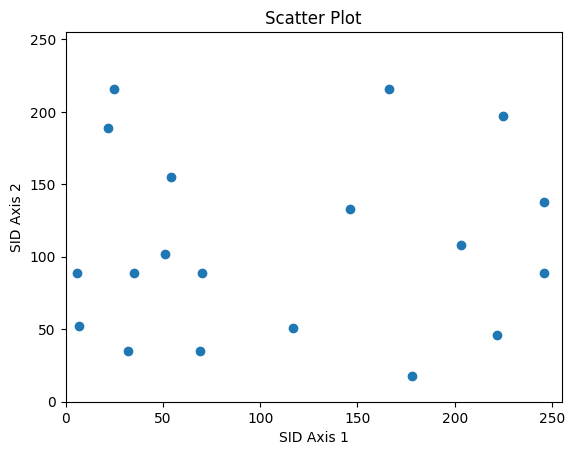

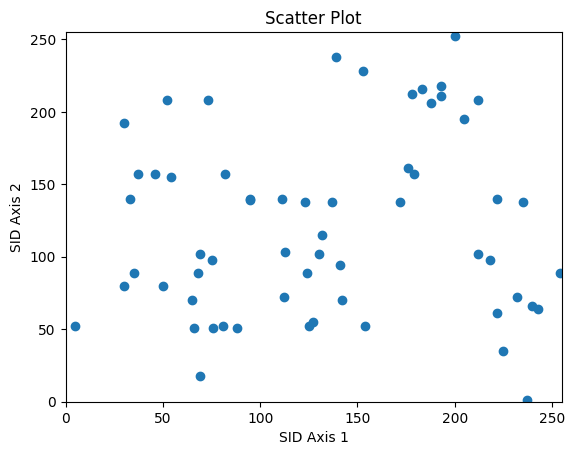

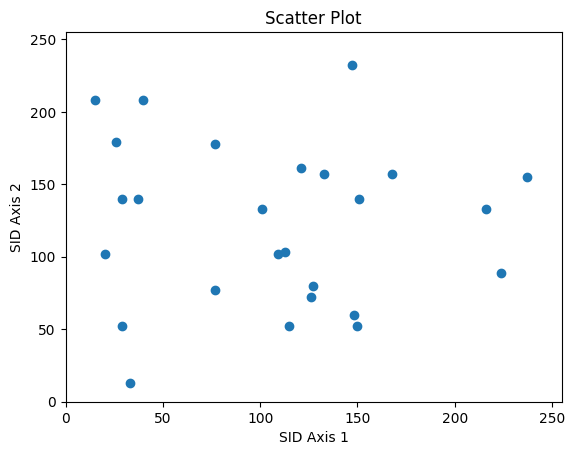

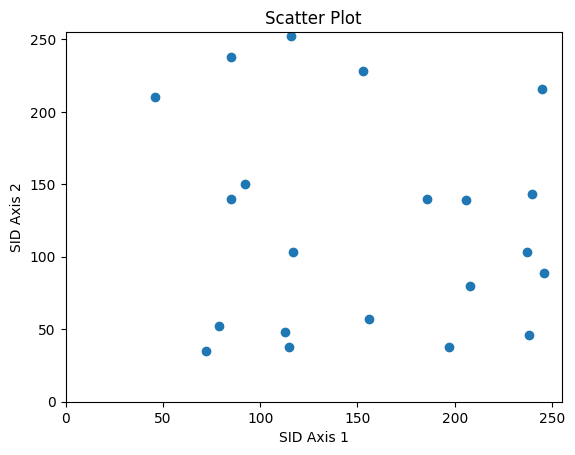

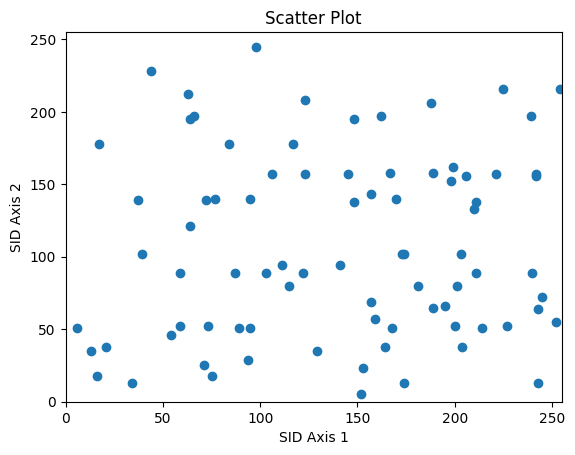

In [350]:
for x in range(5):
    user_id = np.random.randint(0, 1000)
    sem_ids_user = find_sids_for_user(user_id)
    plot_sem_ids(sem_ids_user)

In [ ]:
gpt_gen_1644 = np.array([
 [ 90,  45, 220],
 [142, 199,  30],
 [ 57, 160,  87],
 [121, 195, 189],
 [204,  88, 128],
 [ 43,  65, 223],
 [171, 107,  93],
 [ 19, 154, 212],
 [ 96, 218, 174],
 [250,  34, 106]
])

gpt_gen_1670 = np.array([
[43, 108,  76],
[166, 252,226],
[53, 104, 137],
[159, 47, 166],
[209, 255,148],
[112, 146, 91],
[171, 16, 199],
[163, 110,158],
[185, 153, 72],
[181, 150,173],
])

[3400, 1057, 3464, 398, 3115, 3612, 2465, 2097, 2416, 3265]
